## Current results in this file are still very preliminary
*  This means that time series for some of the wikis are shorter than they could be
* There are still unknown problems with fitting models on srwiki and svwiki

* there are probably some ways to improve the models
* need to correct confidence intervals for multiple hypotheses testing
* there are still unexplained spikes in time-to-revert that I haven't spot checked
* model selection is done stepwise using an approximation method. For the final analysis we should do full search, which will be very slow

* Maybe just have seperate variables for ores models and rcfilters.
* Get into the mindset of treated wikis as cases 
* Aaron expects to find an increase in Persian wikipedia around when dexbot was deployed in persian (2013)
* We should expect ores to have less of an effect on alrady developed systems like huggle, stiki

[X] Either exclude blanks or impose a 30 window. Note that recent changes and watchlists don't go back more than 30 days. So we have a good rationale for the 30 day window.   

Imposed 30 day window

[X] Use autoconfirmed status for "newcomer"

[ ] Are there clear groups around time to revert? 

[ ] What about around threshholds? 

[ ] Look at differences in means, medians, geom_means, density plots of the variables. 

[ ] Make the "when the levy breaks plot"



In [1]:
library(forecast)
library(dotwhisker)


Loading required package: ggplot2


In [68]:
library(sandwich)                                                                                        
library(sjPlot)                                                                                          
library(lmtest)                                                                                          
library(MASS)                                                                                            
library(aod)                                                                                             
options(mc.cores = parallel::detectCores())                                                              
set.seed(1337)     
wd = '/srv/home/nathante/editquality/bias_analysis'
if(getwd() != wd){
    setwd(wd) 
}

# load some helper code
source("ob_util.R")                                                                                      
source("formulas.r")                                                                                     

In [69]:
# load the date
df <- load_ts_ds()

In [70]:
df <- prepare.df(df)                                                                                     
# exclude these oddballs
# hungarian: had no idea ORES was a think
# turkish: blocked in Turkey
# wikidata: too strange, ORES not considered that useful
df <- df[! (wiki.db %in% c('huwiki','trwiki','wikidatawiki'))]
           

In [71]:
# for some reason we have some weeks from 2025
df <- df[year(week) != 2025]

# There are still problems for svwiki and svwiki

In [72]:
df <- df[wiki.db !='srwiki']

In [73]:
#twinkle is temporarily set to 0
n_revert_model_data <- df[,.(wiki.db,week,undo.N.reverts,rollback.N.reverts,huggle.N.reverts,otherTool.N.reverts,bot.N.reverts,has.ores,cutoff,undo.geom.mean.ttr,rollback.geom.mean.ttr,newcomer.geom.mean.ttr,anonymous.geom.mean.ttr,n.reverts)]
n_revert_model_data <- n_revert_model_data[order(week)]

In [74]:
all_weeks = data.table(week =seq(min(df$week),max(df$week),by='week'))

In [75]:
df = merge(df,all_weeks,fill=0,how='right')

In [76]:
nrevert_model_data <- df[,.(wiki.db,week,has.ores,cutoff,newcomer.N.reverts,anonymous.N.reverts,undo.N.reverts,rollback.N.reverts,bot.N.reverts,geom.mean.ttr,newcomer.geom.mean.ttr,anonymous.geom.mean.ttr,tool.ratio = n.undos / (n.rollbacks + n.undos + 1),n.reverts)]

In [77]:
df[,":="
   (    
       non.bot.reverts = n.reverts - bot.N.reverts
   )]


In [78]:
df[, ":="(undo.geom.mean.ttr.zscore = (undo.geom.mean.ttr - mean(undo.geom.mean.ttr))/sd(undo.geom.mean.ttr)
         ), by=.(wiki.db)]

# Undo reverts

In [115]:
?auto.arima

In [116]:
fit_models <- function(n_revert_model_data, dv){
    nrevert_arima_models <- list()
    for(wiki in unique(n_revert_model_data$wiki.db)){
        
        model_data <- n_revert_model_data[wiki.db == wiki]
        model_data <- model_data[,(dv) := scale(model_data[[dv]],center=F,scale=T)]
        # for the final analysis we shouldn't use stepwise selection
        #        fit.model <- auto.arima(y = model_data[[dv]],xreg=as.numeric(model_data$has.ores),ic='bic',parallel=T,stepwise=F,approximation=F,num.cores=20)
        y <- model_data[[dv]]
        if(sum(y,na.rm=T) == 0){
            print(paste(wiki,"is all 0 for this measure"))
            next
        }
        fit.model <- auto.arima(y,xreg=as.numeric(model_data$has.ores),ic='aicc')
        nrevert_arima_models[[wiki]] <- fit.model
        
        n_revert_model_data[wiki.db==wiki, (paste0('pred_',dv)) := fit.model$fitted]
        n_revert_model_data[wiki.db==wiki, (paste0('scaled_',dv)) :=  model_data[[dv]]]

    }
    return( list(n_revert_model_data = n_revert_model_data, nrevert_arima_models=nrevert_arima_models))
}

In [117]:
get_est_interval <- function(model, name='xreg'){
    est <- coef(model)['xreg']
    var <- vcov(model)['xreg','xreg']
    se <- sqrt(var)
    list(lower = est - 1.96*se, est = est, upper = est + 1.96*se)
}

In [118]:
plot_model_fit <- function(n_revert_model_data, dv){
    undos_model_data <- fit_models(n_revert_model_data, dv)    
    n_revert_plot_data <- melt(n_revert_model_data,measure.vars = c(paste0('pred_',dv),paste0('scaled_',dv)))
    p <- ggplot(n_revert_plot_data,aes(x=week,y=value,group=variable,color=variable)) + geom_line(alpha=0.5) + geom_vline(aes(xintercept=cutoff),linetype=2) + facet_wrap(.~wiki.db,scale='free',ncol=1)
    ggsave(paste0("saved_plots/fitted_",dv,'.pdf'), p, 'pdf', height=40)
    return(p)
}


# Still a problem with svwiki in below cell

In [119]:
plot_model_coefficients <- function(fit_models, dv){
    plot_nrevert_data <- rbindlist(lapply(fit_models,get_est_interval))
    plot_nrevert_data$wiki_db = names(fit_models)
    plot_nrevert_data <- plot_nrevert_data[order(-est)]
    plot_nrevert_data[,wiki_db := gsub("wiki","",wiki_db)]
    
    plot_nrevert_data <- plot_nrevert_data[wiki_db != 'svwiki']
    plot_nrevert_data[,wiki_db := factor(wiki_db,levels=plot_nrevert_data[order(-est)]$wiki_db)]
    plot_nrevert_data[lower > 0, sig := 'gtzero']
    plot_nrevert_data[upper < 0, sig := 'ltzero']
    plot_nrevert_data[ (lower < 0) & (upper > 0), sig := 'nonsig']
    p <- ggplot(plot_nrevert_data, aes(x=wiki_db,y=est,ymax=upper,ymin=lower,color=sig)) + geom_pointrange() + ggtitle(paste0("Model estimates for ", dv))
    ggsave(paste0("saved_plots/coefficients_",dv,'.pdf'))
    return(p)
}

In [120]:
getwd()

[1] "/srv/home/nathante/editquality/bias_analysis"

In [136]:
model_timeseries <- function(nrevert_model_data,dv){
    res <- fit_models(nrevert_model_data,dv)
    n_revert_model_data <- res$nrevert_model_data
    undo_models <- res$nrevert_arima_models
    p1 <- plot_model_fit(nrevert_model_data, dv)
    p2 <- plot_model_coefficients(undo_models,dv)
    return(list(plot=p2,models=undo_models,dv=dv))
}

In [137]:
grepl("n.revert",names(nrevert_model_data))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [138]:
res = model_timeseries(nrevert_model_data,'n.reverts')

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


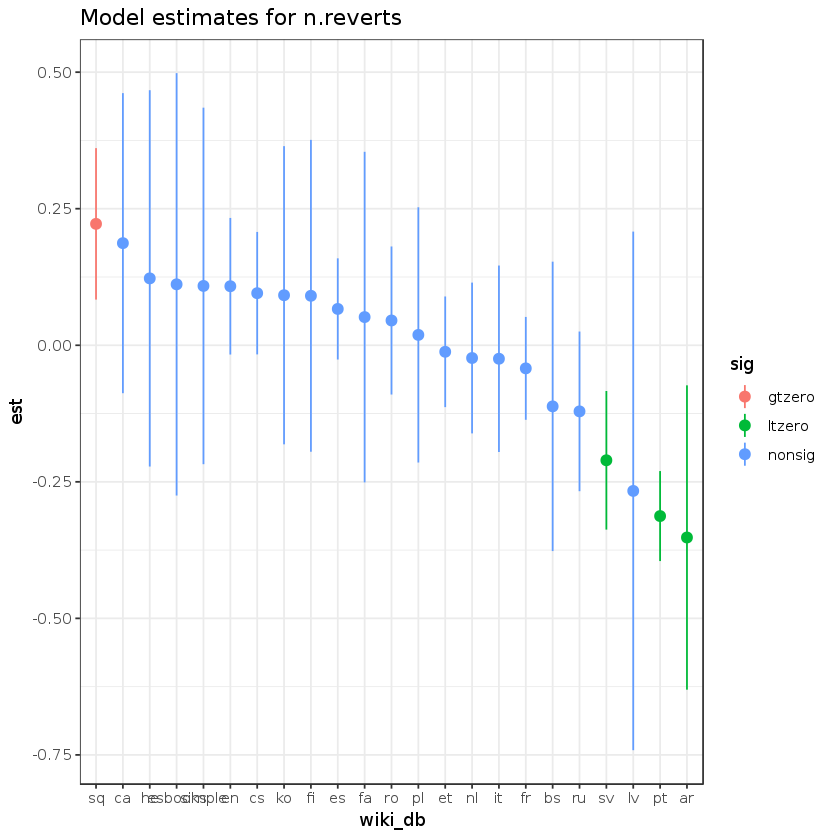

In [139]:
res$plot

In [ ]:
-0.26 + 1.96*0.235

In [150]:
summary(res$models["lvwiki"]$lvwiki)

Series: y 
Regression with ARIMA(1,1,2) errors 

Coefficients:
         ar1      ma1     ma2     xreg
      0.8889  -1.5483  0.5596  -0.2667
s.e.  0.0313   0.0423  0.0379   0.2422

sigma^2 estimated as 0.1448:  log likelihood=-869.86
AIC=1749.72   AICc=1749.75   BIC=1777.54

Training set error measures:
                      ME    RMSE       MAE       MPE     MAPE    MASE
Training set 0.006896368 0.37999 0.1604678 -12.07505 25.74216 1.52943
                    ACF1
Training set 0.006036622


In [135]:
undo_models

ERROR: Error in eval(expr, envir, enclos): object 'undo_models' not found


Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


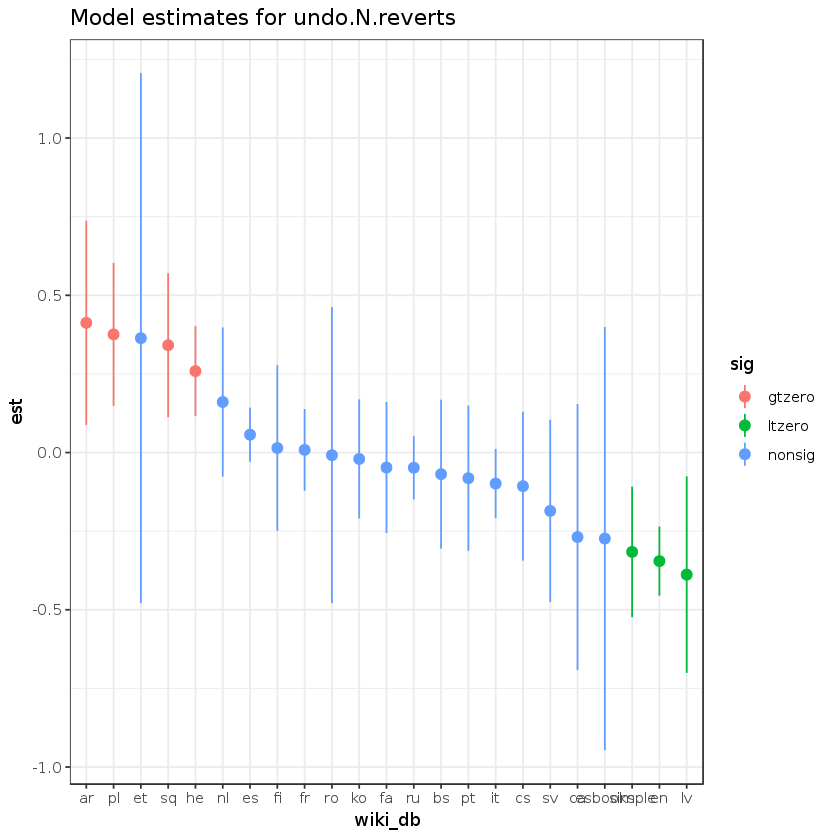

In [124]:
model_timeseries(nrevert_model_data,'undo.N.reverts')

[1] "bswiki is all 0 for this measure"
[1] "bswiki is all 0 for this measure"


Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


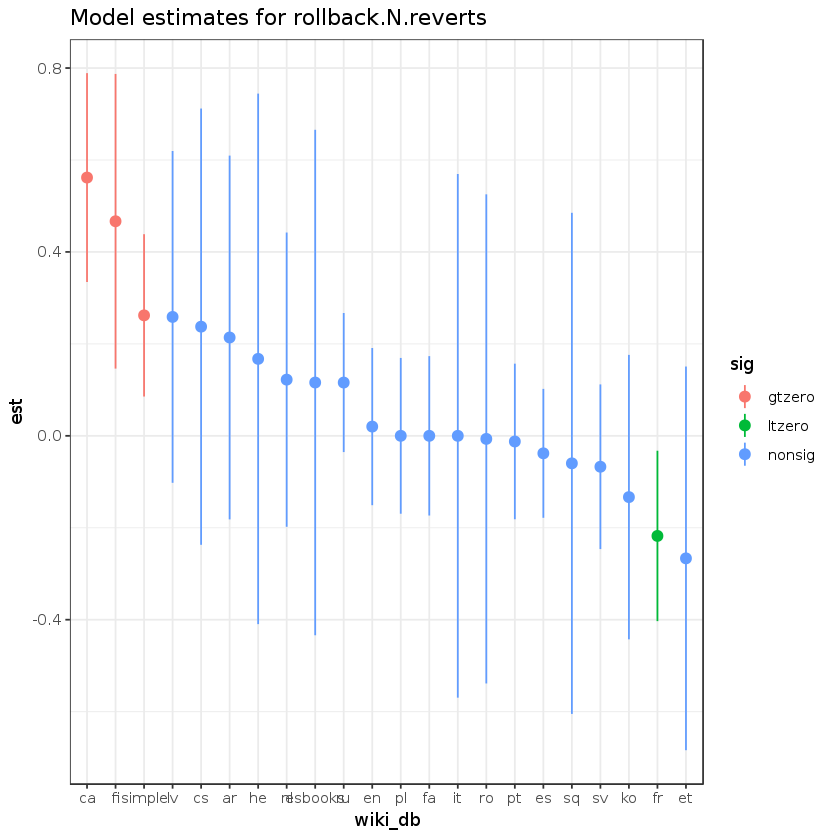

In [125]:
model_timeseries(nrevert_model_data,'rollback.N.reverts')

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


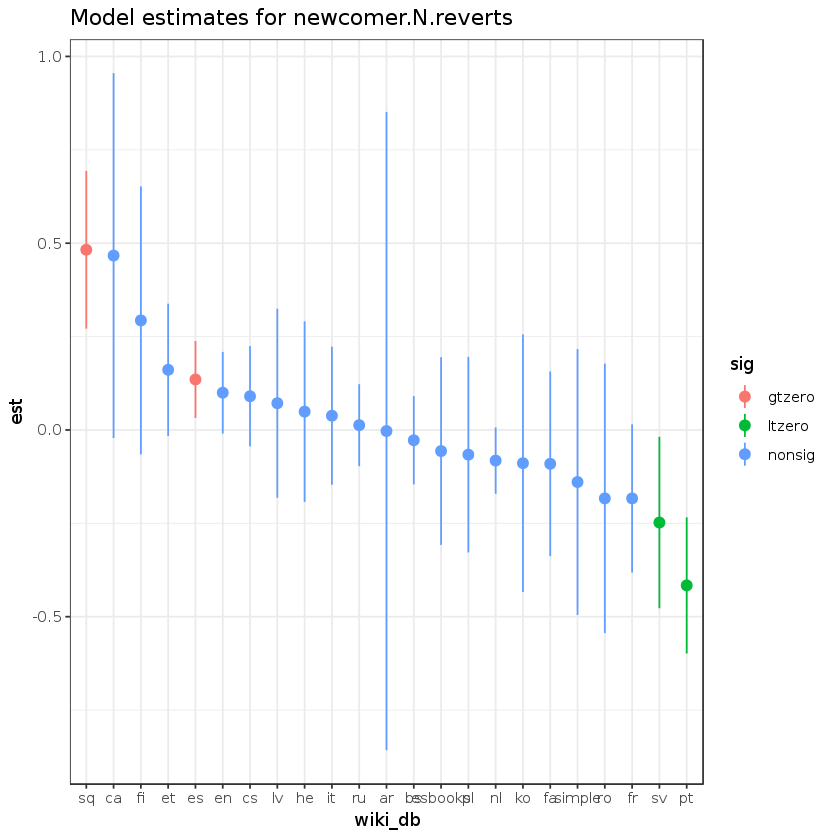

In [126]:
model_timeseries(nrevert_model_data,'newcomer.N.reverts')

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


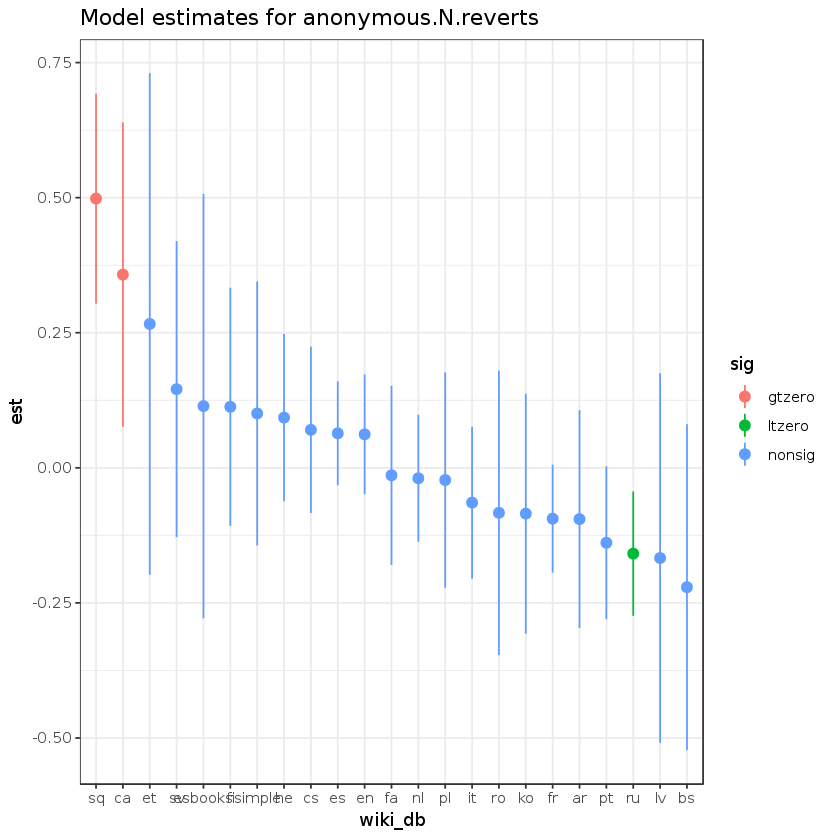

In [127]:
model_timeseries(nrevert_model_data,'anonymous.N.reverts')

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


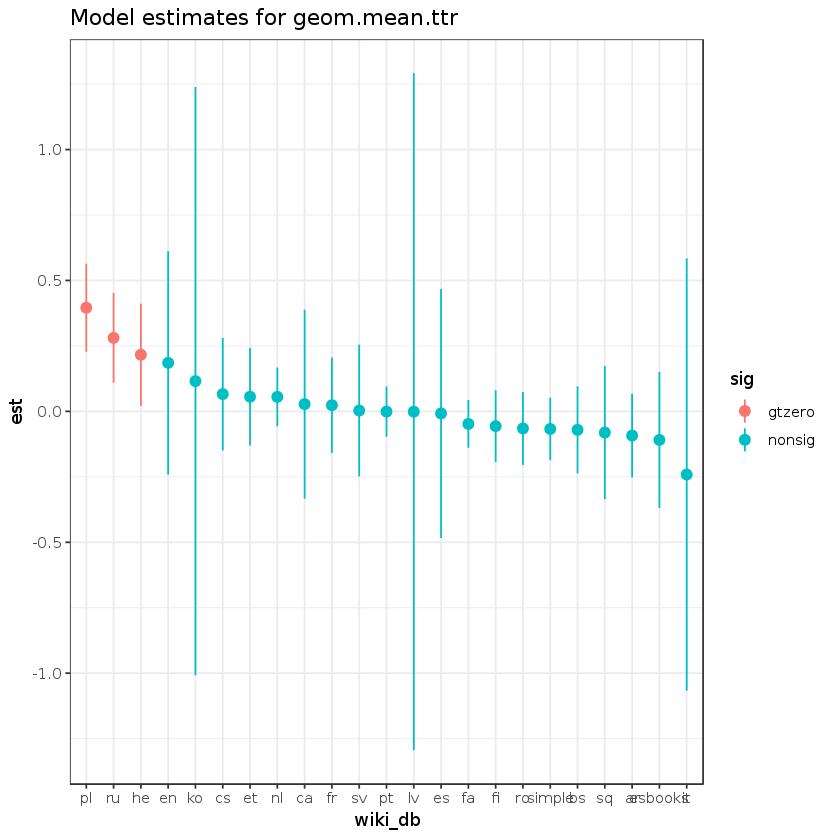

In [128]:
model_timeseries(nrevert_model_data,'geom.mean.ttr')

# negative estimates for tool ratio are interpreted as a decrease in undo reversion relative to rollback reversion

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


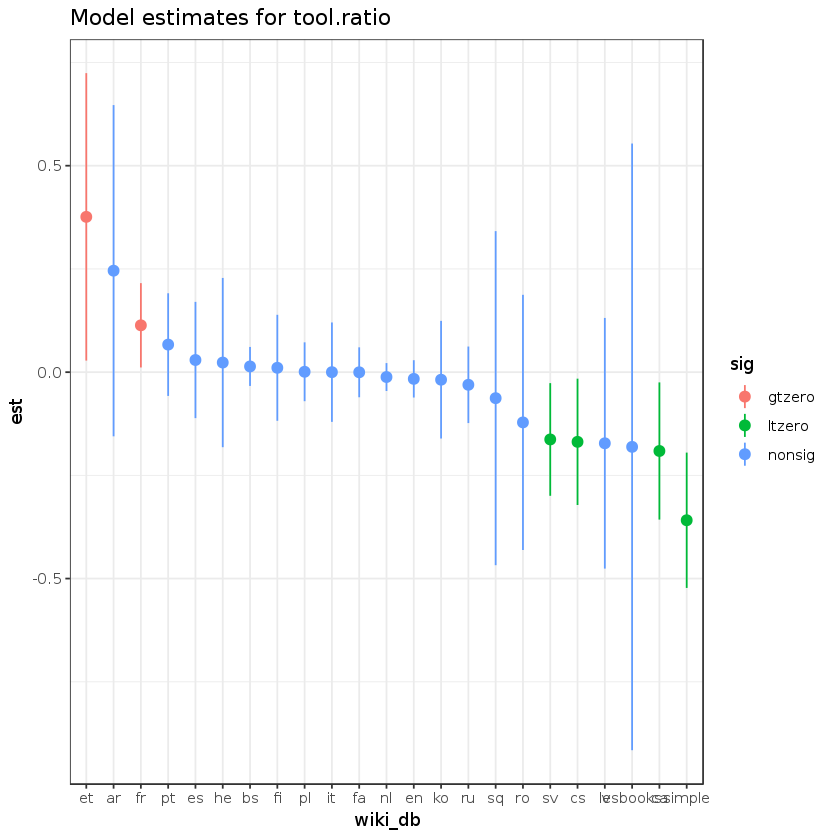

In [129]:
model_timeseries(nrevert_model_data,'tool.ratio')

In [130]:
names(nrevert_model_data)

[1] "wiki.db"                        "week"                          
 [3] "has.ores"                       "cutoff"                        
 [5] "newcomer.N.reverts"             "anonymous.N.reverts"           
 [7] "undo.N.reverts"                 "rollback.N.reverts"            
 [9] "bot.N.reverts"                  "geom.mean.ttr"                 
[11] "newcomer.geom.mean.ttr"         "anonymous.geom.mean.ttr"       
[13] "tool.ratio"                     "n.reverts"                     
[15] "pred_n.reverts"                 "scaled_n.reverts"              
[17] "pred_undo.N.reverts"            "scaled_undo.N.reverts"         
[19] "pred_rollback.N.reverts"        "scaled_rollback.N.reverts"     
[21] "pred_newcomer.N.reverts"        "scaled_newcomer.N.reverts"     
[23] "pred_anonymous.N.reverts"       "scaled_anonymous.N.reverts"    
[25] "pred_geom.mean.ttr"             "scaled_geom.mean.ttr"          
[27] "pred_tool.ratio"                "scaled_tool.ratio"             
[29] "pred_newcomer.geom.mean.ttr"    "scaled_newcomer.geom.mean.ttr" 
[31] "pred_anonymous.geom.mean.ttr"   "scaled_anonymous.geom.mean.ttr"
[33] "pred_bot.N.reverts"             "scaled_bot.N.reverts"

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


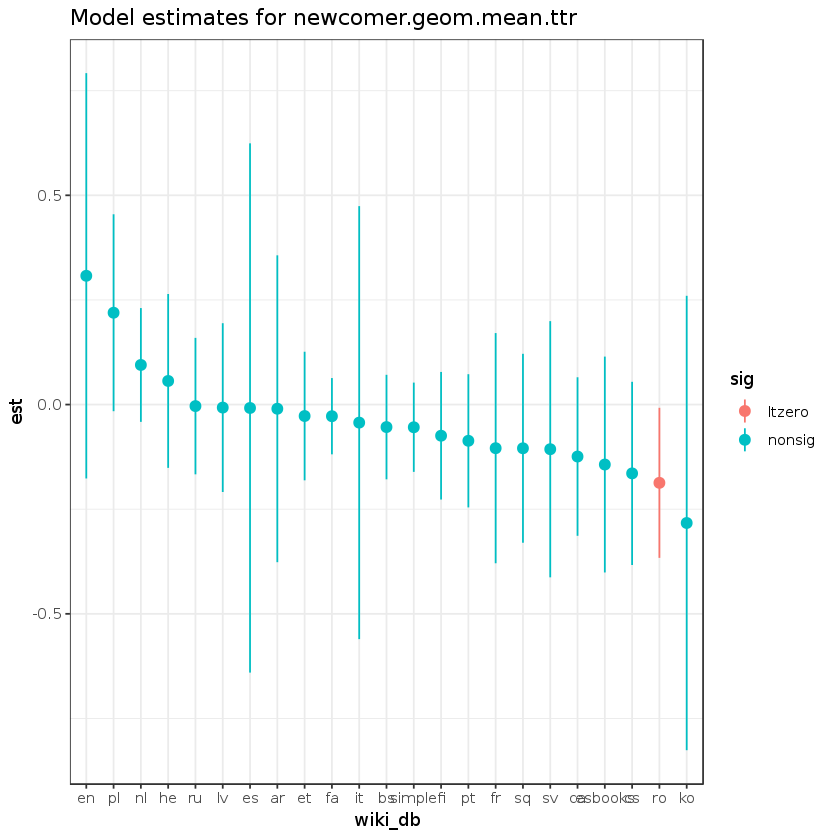

In [131]:
model_timeseries(nrevert_model_data,'newcomer.geom.mean.ttr')

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


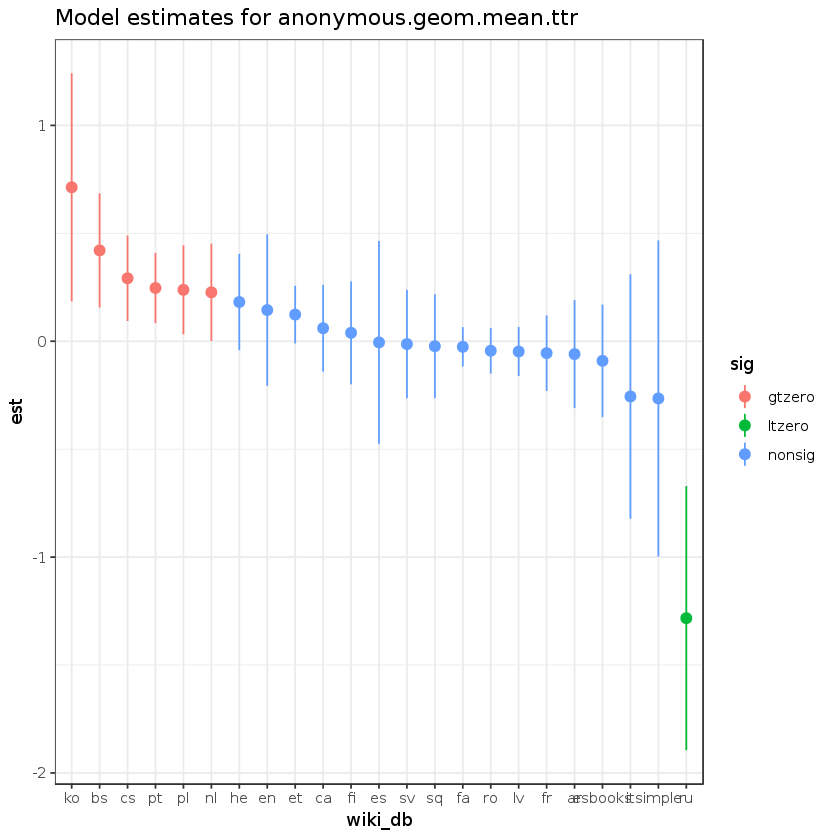

In [132]:
model_timeseries(nrevert_model_data,'anonymous.geom.mean.ttr')

Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Saving 6.67 x 6.67 in image


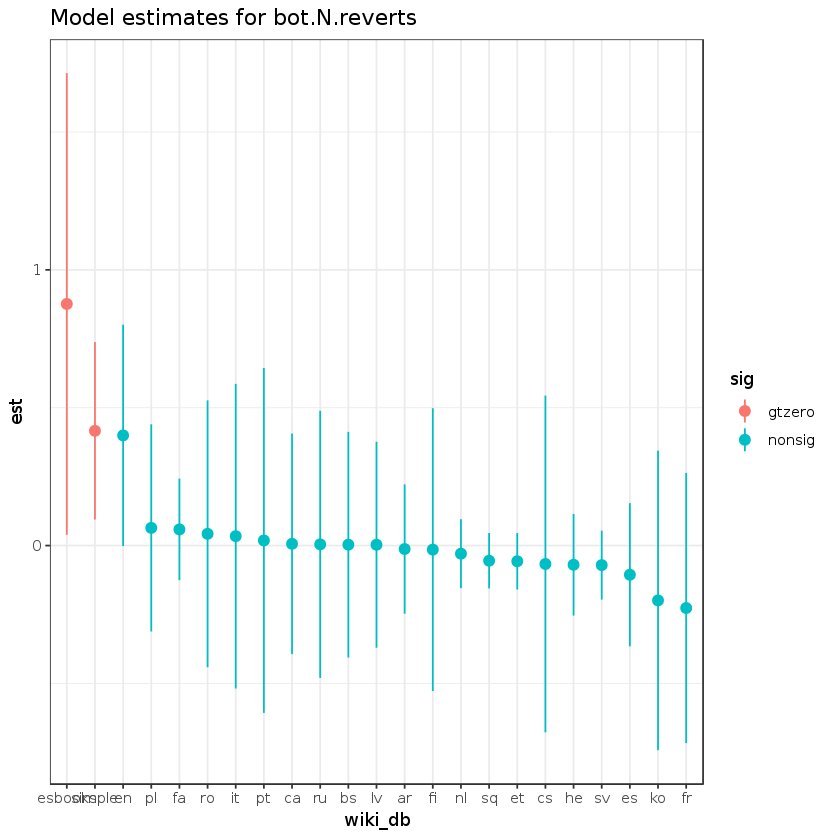

In [133]:
model_timeseries(nrevert_model_data,'bot.N.reverts')

In [50]:
res <- fit_models(nrevert_model_data, dv)

In [51]:
n_revert_model_data <- res$n_revert_model_data
undo_models <- res$nrevert_arima_models


Saving 6.67 x 40 in image
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


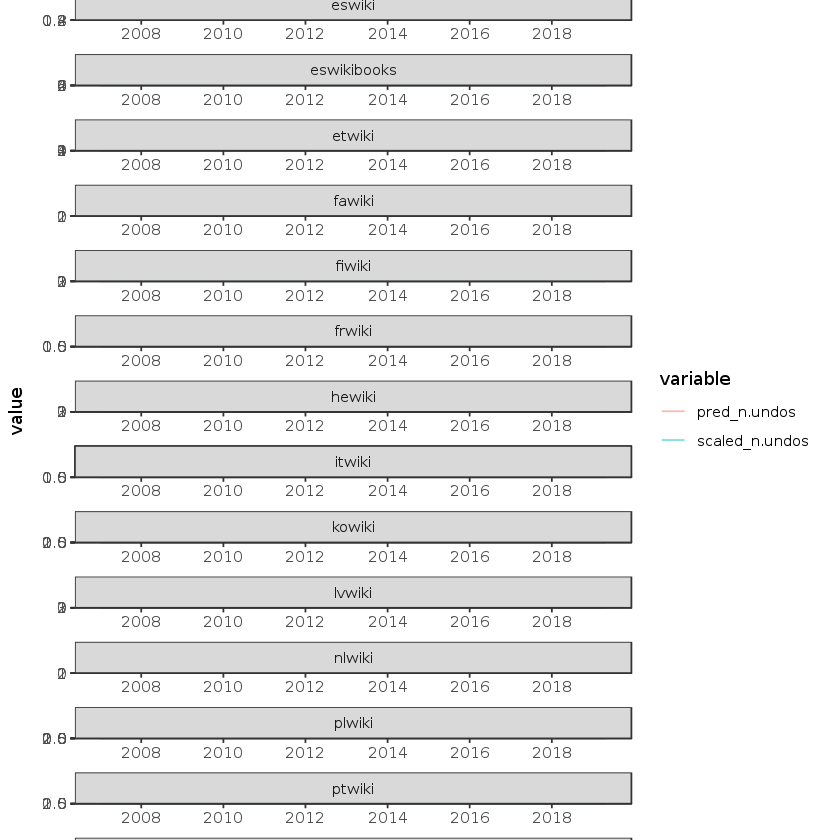

In [52]:
plot_model_coefficients(undo, dv)

## Dependent variables to analyze
* Number of reverts by tool
* ratio of popular tool (undo) to exclusive tool (rollback)
* time to revert
* Number of reverts by editor type

In [ ]:
dvs = c('undo.N.revert','rollback.N.revert','undo.rollback.ratio','bot.N.revert','newcomer.undo.N.revert','anonymous.undo.N.revert',' newcomer.rollback.N.revert','anonymous.undo.N.'

# Routine for making "secret weapon" plots
1. Build a table of the form <wiki, lower, estimate, upper>
2. plot point ranges. 

#Rollback reverts

In [ ]:
rollbacks_model_data <- fit_models()


In [ ]:
model_data <- df[,.(week,wiki.db,geom.mean.ttr,n.reverts,)]

In [204]:
?melt

In [ ]:
n_revert_model_data

In [213]:
y <- n_revert_model_data$n.reverts
xreg <- as.matrix(n_revert_model_data[,.(undo,rollback,huggle,other,twinkle,bot,has_ores)]

[1] "wiki.db"                           "week"                             
  [3] "mean.user.reverts"                 "n.reverts"                        
  [5] "user.week.var"                     "revert.hhi"                       
  [7] "user.week.sd"                      "user.week.revert.cv"              
  [9] "total.edits"                       "active.editors"                   
 [11] "mean.ttr"                          "sd.ttr"                           
 [13] "geom.mean.ttr"                     "med.ttr"                          
 [15] "N.revert"                          "admin.undo.mean.ttr"              
 [17] "admin.undo.sd.ttr"                 "admin.undo.geom.mean.ttr"         
 [19] "admin.undo.med.ttr"                "admin.undo.N.reverts"             
 [21] "admin.rollback.mean.ttr"           "admin.rollback.sd.ttr"            
 [23] "admin.rollback.geom.mean.ttr"      "admin.rollback.med.ttr"           
 [25] "admin.rollback.N.reverts"          "admin.huggle.mean.ttr"            
 [27] "admin.huggle.sd.ttr"               "admin.huggle.geom.mean.ttr"       
 [29] "admin.huggle.med.ttr"              "admin.huggle.N.reverts"           
 [31] "admin.otherTool.mean.ttr"          "admin.otherTool.sd.ttr"           
 [33] "admin.otherTool.geom.mean.ttr"     "admin.otherTool.med.ttr"          
 [35] "admin.otherTool.N.reverts"         "bot.undo.mean.ttr"                
 [37] "bot.undo.sd.ttr"                   "bot.undo.geom.mean.ttr"           
 [39] "bot.undo.med.ttr"                  "bot.undo.N.reverts"               
 [41] "bot.rollback.mean.ttr"             "bot.rollback.sd.ttr"              
 [43] "bot.rollback.geom.mean.ttr"        "bot.rollback.med.ttr"             
 [45] "bot.rollback.N.reverts"            "bot.huggle.mean.ttr"              
 [47] "bot.huggle.sd.ttr"                 "bot.huggle.geom.mean.ttr"         
 [49] "bot.huggle.med.ttr"                "bot.huggle.N.reverts"             
 [51] "bot.otherTool.mean.ttr"            "bot.otherTool.sd.ttr"             
 [53] "bot.otherTool.geom.mean.ttr"       "bot.otherTool.med.ttr"            
 [55] "bot.otherTool.N.reverts"           "patroller.undo.mean.ttr"          
 [57] "patroller.undo.sd.ttr"             "patroller.undo.geom.mean.ttr"     
 [59] "patroller.undo.med.ttr"            "patroller.undo.N.reverts"         
 [61] "patroller.rollback.mean.ttr"       "patroller.rollback.sd.ttr"        
 [63] "patroller.rollback.geom.mean.ttr"  "patroller.rollback.med.ttr"       
 [65] "patroller.rollback.N.reverts"      "patroller.huggle.mean.ttr"        
 [67] "patroller.huggle.sd.ttr"           "patroller.huggle.geom.mean.ttr"   
 [69] "patroller.huggle.med.ttr"          "patroller.huggle.N.reverts"       
 [71] "patroller.otherTool.mean.ttr"      "patroller.otherTool.sd.ttr"       
 [73] "patroller.otherTool.geom.mean.ttr" "patroller.otherTool.med.ttr"      
 [75] "patroller.otherTool.N.reverts"     "other.undo.mean.ttr"              
 [77] "other.undo.sd.ttr"                 "other.undo.geom.mean.ttr"         
 [79] "other.undo.med.ttr"                "other.undo.N.reverts"             
 [81] "other.rollback.mean.ttr"           "other.rollback.sd.ttr"            
 [83] "other.rollback.geom.mean.ttr"      "other.rollback.med.ttr"           
 [85] "other.rollback.N.reverts"          "other.huggle.mean.ttr"            
 [87] "other.huggle.sd.ttr"               "other.huggle.geom.mean.ttr"       
 [89] "other.huggle.med.ttr"              "other.huggle.N.reverts"           
 [91] "other.otherTool.mean.ttr"          "other.otherTool.sd.ttr"           
 [93] "other.otherTool.geom.mean.ttr"     "other.otherTool.med.ttr"          
 [95] "other.otherTool.N.reverts"         "ns0.anon.N.edits"                 
 [97] "ns0.anon.N.editors"                "ns0.newcomer.N.edits"             
 [99] "ns0.newcomer.N.editors"            "ns0.non.anon.newcomer.N.edits"    
[101] "ns0.non.anon.newcomer.N.editors"   "ns1.anon.N.edits"                 
[103] "ns1.anon.N.editor

In [201]:
#after some spotchecks I think these spikes can be real: but are likely due to bot activity or reverts on some old pages. Median is more robust to outliers, but always very close to zero, may have error due to use of Percentile approximation in spark and may not have enough variation. So let's go with geom_mean

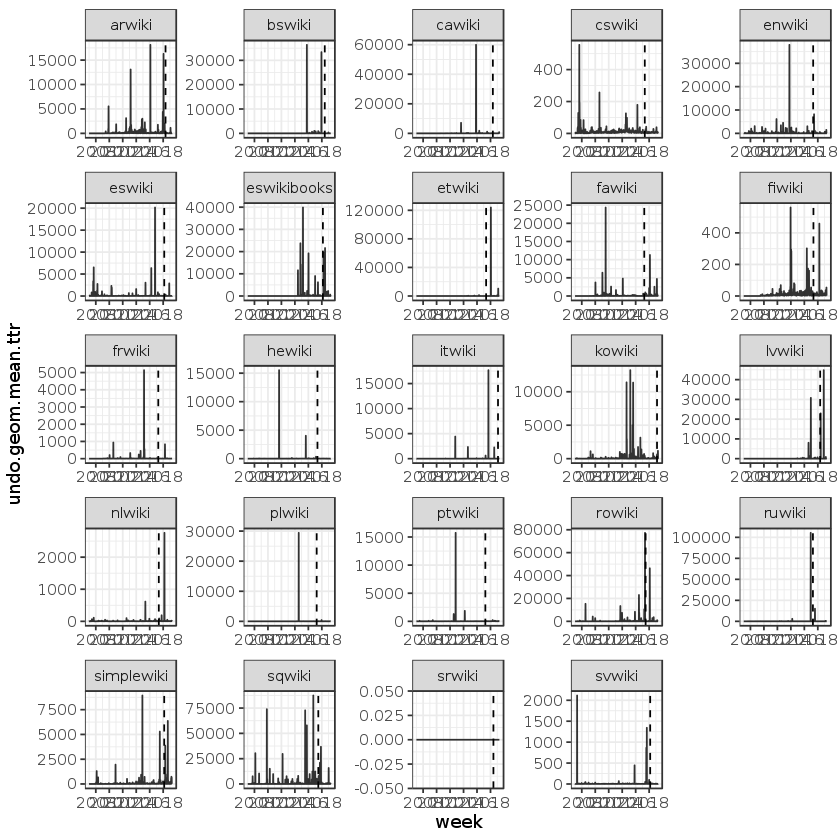

In [202]:
ggplot(df, aes(x=week,y=undo.geom.mean.ttr)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=cutoff),linetype='dashed') + facet_wrap(.~wiki.db,scales='free')

In [176]:
fr = df[wiki.db=='frwiki']

In [177]:
fr[n.reverts == max(fr$n.reverts), .(week,n.reverts,undo.N.reverts,rollback.N.reverts,huggle.N.reverts)]

week,n.reverts,undo.N.reverts,rollback.N.reverts,huggle.N.reverts
2013-03-11,24992,1970,2592,0


In [178]:
# what happened on huwiki? It seems like they went from having it configured using Mediawiki:undo-summary to using the language defualt. It's ok since we'll exclude them anyway.

In [179]:
hu = df[wiki.db=='huwiki']

In [180]:
lubridate::ymd("2014-03-01")

[1] "2014-03-01"

Warning message in melt.data.table(ar, measure.vars = c("non.bot.reverts", "n.reverts", :
“'measure.vars' [non.bot.reverts, n.reverts, n.undos, n.rollbacks] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”

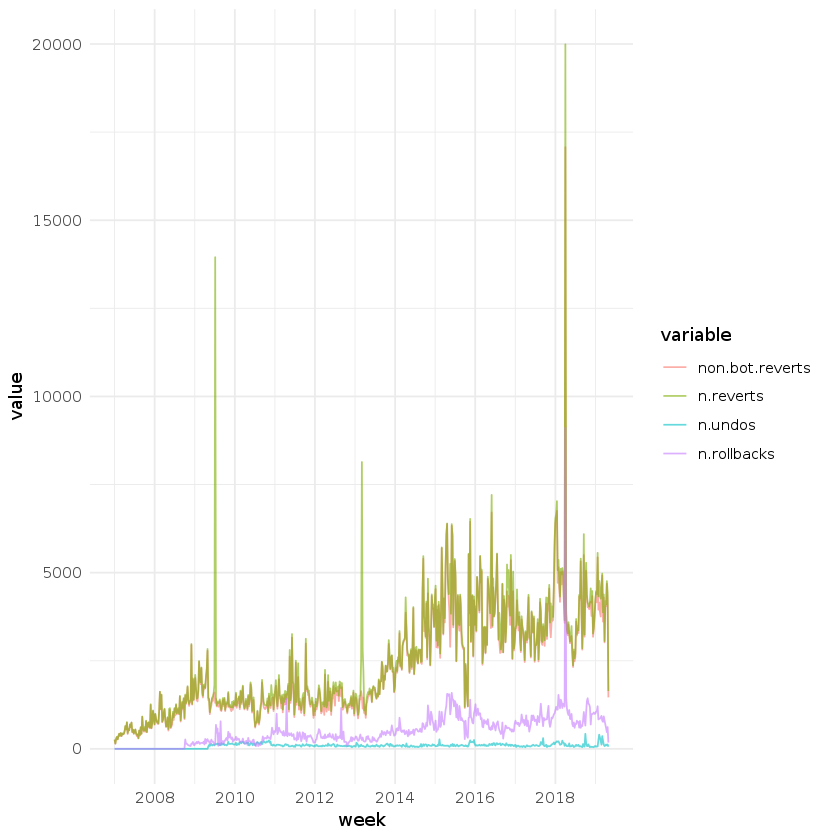

In [181]:
# what's going on in arwiki? Based on spotchecks the spikes seem real and like ORES triggered a flurry of activity. 
ar = df[wiki.db == 'arwiki',.(week,non.bot.reverts,n.reverts,n.undos,n.rollbacks)]
artab = melt(ar,measure.vars = c('non.bot.reverts','n.reverts','n.undos','n.rollbacks'))
ggplot(artab,aes(x=week,y=value,group=variable,color=variable)) + geom_line(alpha=0.6)

In [142]:
ar[n.reverts == max(n.reverts),.(week,n.reverts,n.undos,n.rollbacks,non.bot.reverts)]

week,n.reverts,n.undos,n.rollbacks,non.bot.reverts
2018-04-02,19990,139,9109,17071
2018-04-02,19990,139,9109,17071
2018-04-02,19990,139,9109,17071
2018-04-02,19990,139,9109,17071
2018-04-02,19990,139,9109,17071
2018-04-02,19990,139,9109,17071
2018-04-02,19990,139,9109,17071


In [ ]:
ggplot(df,aes(x=week,y=rollback.N.reverts)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=cutoff),linetype='dashed') + facet_wrap(.~wiki.db,scales = 'free')

In [ ]:
ggplot(df,aes(x=week,y=non.bot.reverts)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=cutoff),linetype='dashed') + facet_wrap(.~wiki.db,scales = 'free')

In [ ]:
ggplot(df, aes(x=week,y=n.reverts)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=cutoff),linetype='dashed') + facet_wrap(.~wiki.db,scales = 'free')


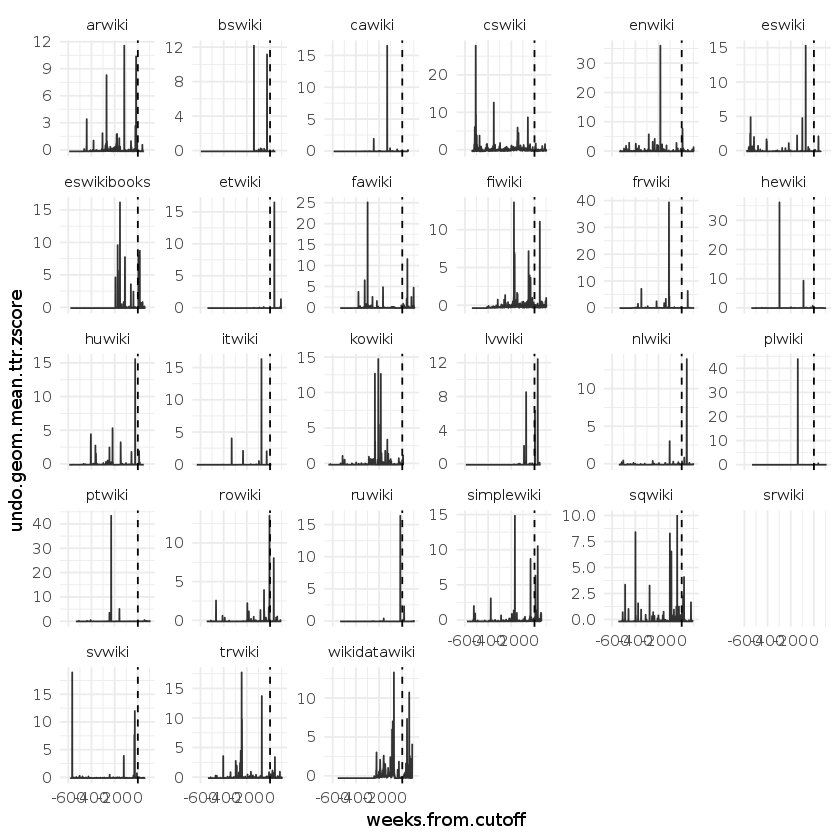

In [65]:
ggplot(df[treated==T], aes(x=weeks.from.cutoff,y=undo.geom.mean.ttr.zscore)) + geom_line(alpha=0.8) + geom_vline(xintercept=0,linetype='dashed') + facet_wrap(.~wiki.db,scales = 'free_yk')

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'n.anon.reverts.zscore' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(

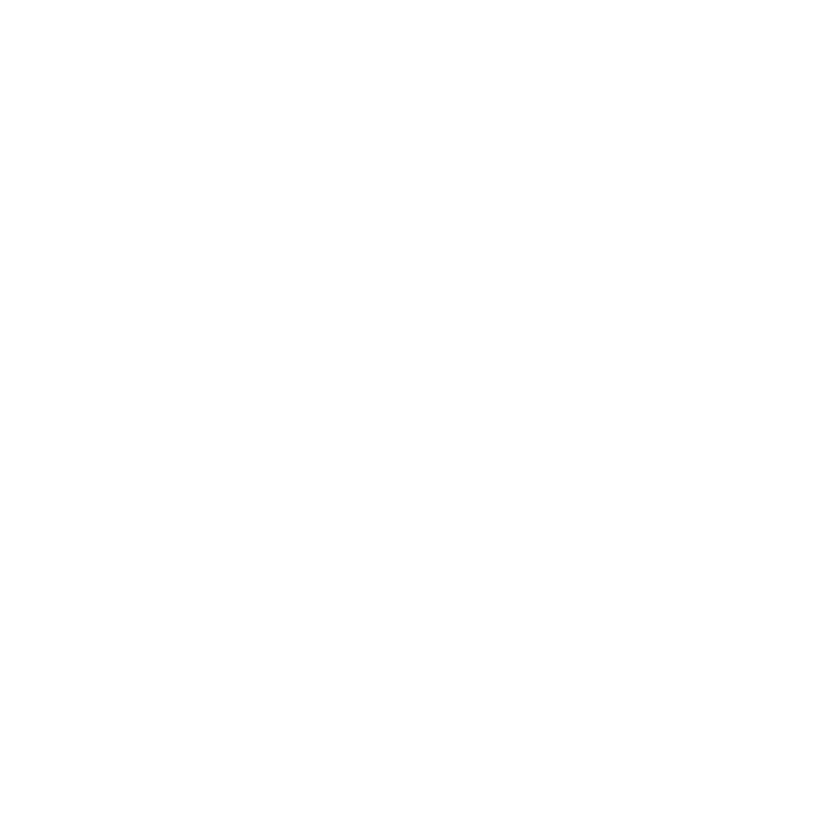

In [15]:
ggplot(df[treated==T], aes(x=weeks.from.cutoff,y=n.anon.reverts.zscore)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=0),data=df[treated==T],linetype='dashed') + facet_wrap(.~wiki.db)

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'n.reverts.zscore' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)


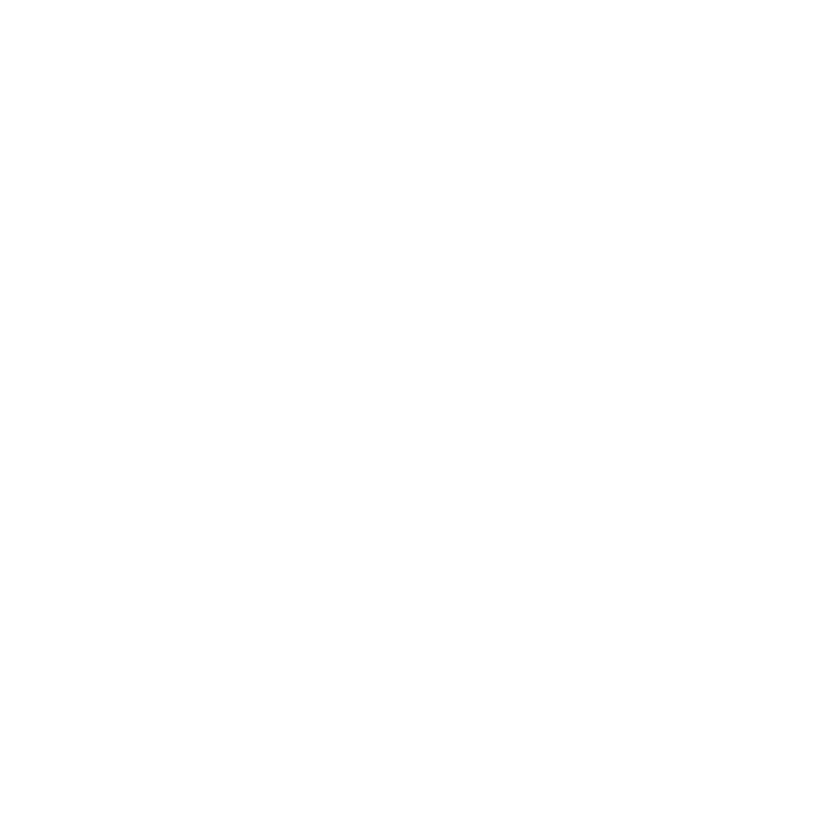

In [16]:
ggplot(df[treated==T], aes(x=week,y=n.reverts.zscore)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=cutoff),data=df[treated==T],linetype='dashed') + facet_wrap(.~wiki.db)

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'n.reverts.zscore' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)


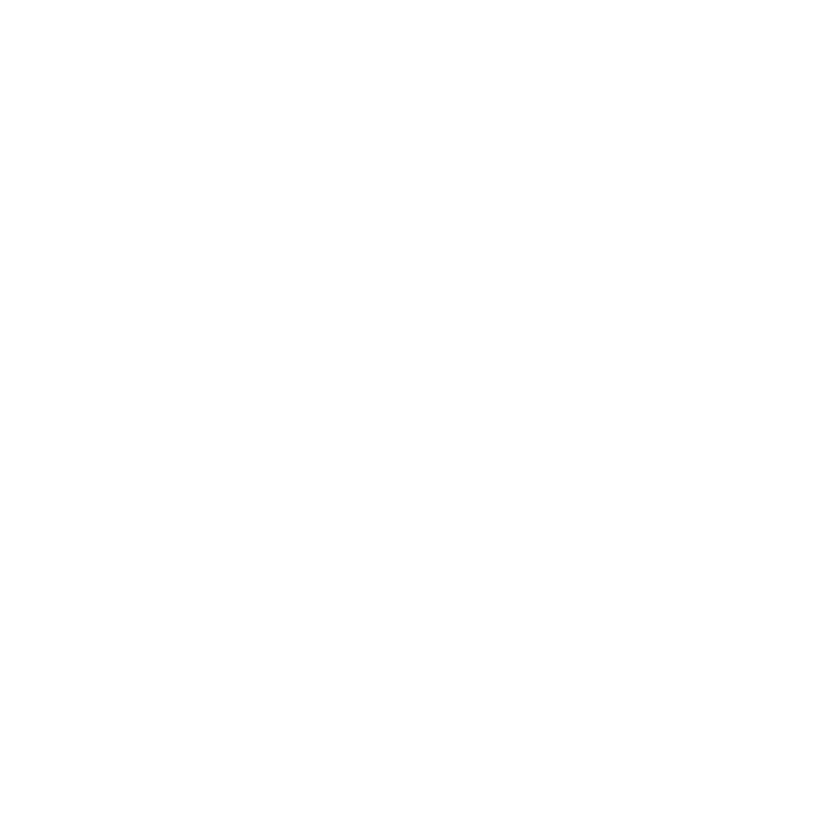

In [17]:
ggplot(df[treated==T], aes(x=weeks.from.cutoff,y=n.reverts.zscore)) + geom_line(alpha=0.8) + geom_vline(aes(xintercept=0),data=df[treated==T],linetype='dashed') + facet_wrap(.~wiki.db)

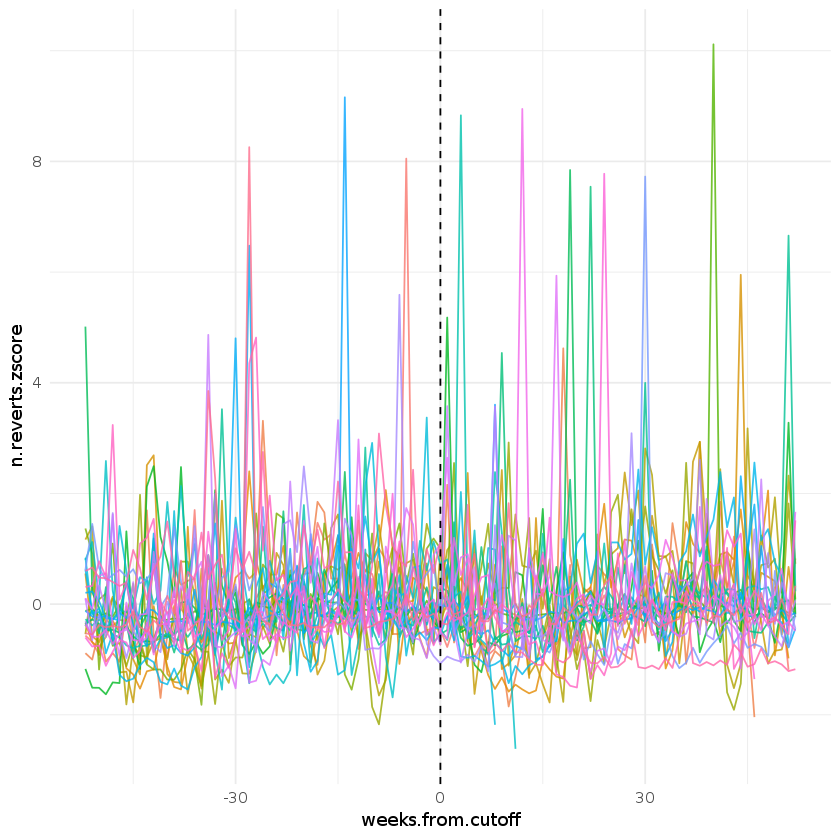

In [377]:
ggplot(df[treated==T], aes(x=weeks.from.cutoff,y=n.reverts.zscore, group=wiki.db, color=wiki.db)) + geom_line(alpha=0.8) + theme(legend.position="none") + geom_vline(xintercept=0,linetype='dashed')

In [378]:
# persian and spanish have revert bots and may have deployed them even before rcfilters (at least in Persian)
# so maybe we also want to use a different cutoff for those wkis 

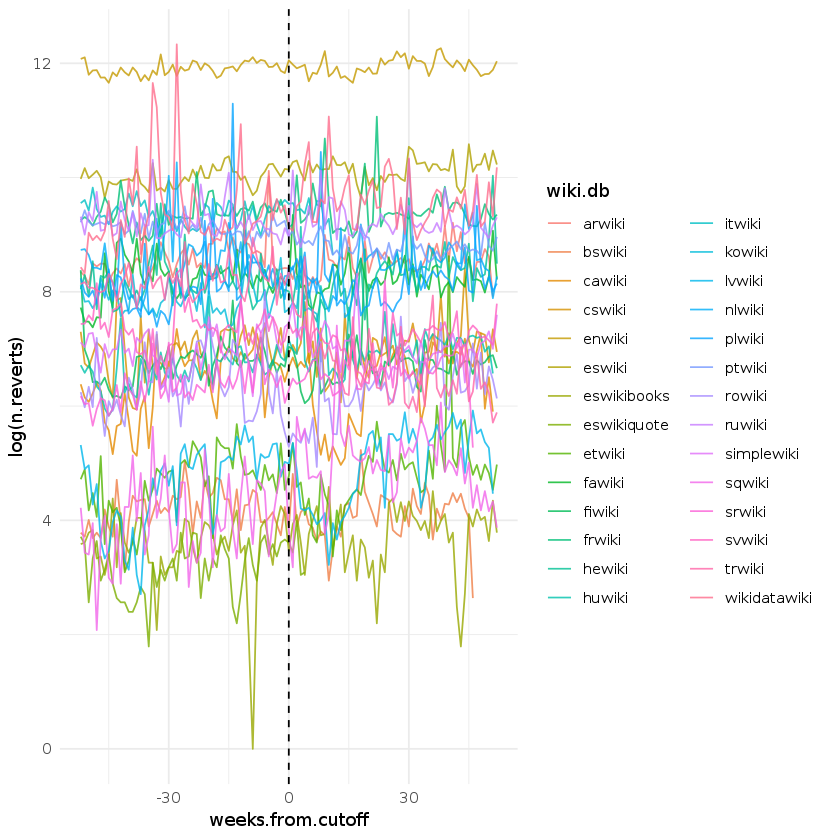

In [379]:
# what are these spikes
ggplot(df[treated==T], aes(x=weeks.from.cutoff,y=log(n.reverts), group=wiki.db, color=wiki.db)) + geom_line(alpha=0.8) + geom_vline(xintercept=0,linetype='dashed')

In [296]:
names(df)

[1] "wiki.db"                         "week"                           
  [3] "mean.user.reverts"               "n.reverts"                      
  [5] "user.week.var"                   "revert.hhi"                     
  [7] "user.week.sd"                    "user.week.revert.cv"            
  [9] "total.edits"                     "active.editors"                 
 [11] "mean.ttr"                        "sd.ttr"                         
 [13] "geom.mean.ttr"                   "med.ttr"                        
 [15] "N.revert"                        "admin.mean.ttr"                 
 [17] "admin.sd.ttr"                    "admin.geom.mean.ttr"            
 [19] "admin.med.ttr"                   "admin.N.reverts"                
 [21] "bot.mean.ttr"                    "bot.sd.ttr"                     
 [23] "bot.geom.mean.ttr"               "bot.med.ttr"                    
 [25] "bot.N.reverts"                   "patroller.mean.ttr"             
 [27] "patroller.sd.ttr"                "patroller.geom.mean.ttr"        
 [29] "patroller.med.ttr"               "patroller.N.reverts"            
 [31] "other.mean.ttr"                  "other.sd.ttr"                   
 [33] "other.geom.mean.ttr"             "other.med.ttr"                  
 [35] "other.N.reverts"                 "newcomer.n.reverted"            
 [37] "newcomer.mean.ttr"               "anonymous.n.reverted"           
 [39] "anonymous.mean.ttr"              "established.n.reverted"         
 [41] "established.mean.ttr"            "ns0.anon.N.edits"               
 [43] "ns0.anon.N.editors"              "ns0.newcomer.N.edits"           
 [45] "ns0.newcomer.N.editors"          "ns0.non.anon.newcomer.N.edits"  
 [47] "ns0.non.anon.newcomer.N.editors" "ns1.anon.N.edits"               
 [49] "ns1.anon.N.editors"              "ns1.newcomer.N.edits"           
 [51] "ns1.newcomer.N.editors"          "ns1.non.anon.newcomer.N.edits"  
 [53] "ns1.non.anon.newcomer.N.editors" "ns2.anon.N.edits"               
 [55] "ns2.anon.N.editors"              "ns2.newcomer.N.edits"           
 [57] "ns2.newcomer.N.editors"          "ns2.non.anon.newcomer.N.edits"  
 [59] "ns2.non.anon.newcomer.N.editors" "ns3.anon.N.edits"               
 [61] "ns3.anon.N.editors"              "ns3.newcomer.N.edits"           
 [63] "ns3.newcomer.N.editors"          "ns3.non.anon.newcomer.N.edits"  
 [65] "ns3.non.anon.newcomer.N.editors" "ns4.anon.N.edits"               
 [67] "ns4.anon.N.editors"              "ns4.newcomer.N.edits"           
 [69] "ns4.newcomer.N.editors"          "ns4.non.anon.newcomer.N.edits"  
 [71] "ns4.non.anon.newcomer.N.editors" "project"                        
 [73] "date"                            "view.count"                     
 [75] "n.pages.created.ns.0"            "n.pages.created.ns.1"           
 [77] "n.pages.created.ns.2"            "n.pages.created.ns.3"           
 [79] "n.pages.created.ns.4"            "n.pages.baseline.ns.0"          
 [81] "n.pages.baseline.ns.1"           "n.pages.baseline.ns.2"          
 [83] "n.pages.baseline.ns.3"           "n.pages.baseline.ns.4"          
 [85] "treated"                         "cutoff"                         
 [87] "weeks.from.cutoff"               "has.ores"                       
 [89] "week.factor"                     "weekly.ns4.edits"               
 [91] "p.ns4.edits.anon"                "p.ns4.edits.newcomer"           
 [93] "p.ns4.edits.established"         "ns0.edits"                      
 [95] "p.ns0.edits.anon"                "p.ns0.edits.newcomer"           
 [97] "p.ns0.edits.established"         "p.reverts.bot"                  
 [99] "p.reverts.admin"                 "p.reverts.patroller"            
[101] "p.reverts.other"                 "n.reverteds"                    
[103] "p.reverteds.newcomer"            "p.reverteds.anonymous"          
[105] "p.reverteds.established"         "has.patrollers"                 
[107] "treated.with.ores"               "treated.y"                      
[109] 

In [298]:
# let's demean and put each wiki on the same scale
df2 <- df[,.(wiki.db, treated, n.reverts,geom.mean.ttr.zscore,n.anon.reverts.zscore,weeks.from.cutoff,ip.weight)]

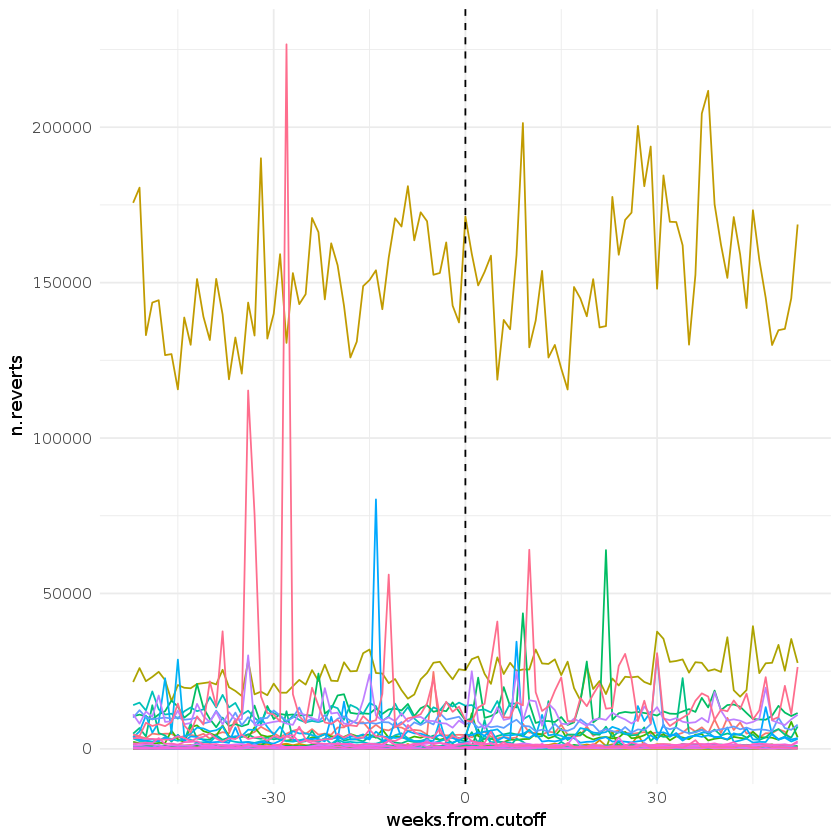

In [380]:
ggplot(df2[treated==T], aes(x=weeks.from.cutoff,y=n.reverts, group=wiki.db, color=wiki.db)) + geom_line() + theme(legend.position="none") + geom_vline(xintercept=0,linetype='dashed')

In [381]:
names(df)

[1] "wiki.db"                         "week"                           
  [3] "mean.user.reverts"               "n.reverts"                      
  [5] "user.week.var"                   "revert.hhi"                     
  [7] "user.week.sd"                    "user.week.revert.cv"            
  [9] "total.edits"                     "active.editors"                 
 [11] "mean.ttr"                        "sd.ttr"                         
 [13] "geom.mean.ttr"                   "med.ttr"                        
 [15] "N.revert"                        "admin.mean.ttr"                 
 [17] "admin.sd.ttr"                    "admin.geom.mean.ttr"            
 [19] "admin.med.ttr"                   "admin.N.reverts"                
 [21] "bot.mean.ttr"                    "bot.sd.ttr"                     
 [23] "bot.geom.mean.ttr"               "bot.med.ttr"                    
 [25] "bot.N.reverts"                   "patroller.mean.ttr"             
 [27] "patroller.sd.ttr"                "patroller.geom.mean.ttr"        
 [29] "patroller.med.ttr"               "patroller.N.reverts"            
 [31] "other.mean.ttr"                  "other.sd.ttr"                   
 [33] "other.geom.mean.ttr"             "other.med.ttr"                  
 [35] "other.N.reverts"                 "newcomer.n.reverted"            
 [37] "newcomer.mean.ttr"               "anonymous.n.reverted"           
 [39] "anonymous.mean.ttr"              "established.n.reverted"         
 [41] "established.mean.ttr"            "ns0.anon.N.edits"               
 [43] "ns0.anon.N.editors"              "ns0.newcomer.N.edits"           
 [45] "ns0.newcomer.N.editors"          "ns0.non.anon.newcomer.N.edits"  
 [47] "ns0.non.anon.newcomer.N.editors" "ns1.anon.N.edits"               
 [49] "ns1.anon.N.editors"              "ns1.newcomer.N.edits"           
 [51] "ns1.newcomer.N.editors"          "ns1.non.anon.newcomer.N.edits"  
 [53] "ns1.non.anon.newcomer.N.editors" "ns2.anon.N.edits"               
 [55] "ns2.anon.N.editors"              "ns2.newcomer.N.edits"           
 [57] "ns2.newcomer.N.editors"          "ns2.non.anon.newcomer.N.edits"  
 [59] "ns2.non.anon.newcomer.N.editors" "ns3.anon.N.edits"               
 [61] "ns3.anon.N.editors"              "ns3.newcomer.N.edits"           
 [63] "ns3.newcomer.N.editors"          "ns3.non.anon.newcomer.N.edits"  
 [65] "ns3.non.anon.newcomer.N.editors" "ns4.anon.N.edits"               
 [67] "ns4.anon.N.editors"              "ns4.newcomer.N.edits"           
 [69] "ns4.newcomer.N.editors"          "ns4.non.anon.newcomer.N.edits"  
 [71] "ns4.non.anon.newcomer.N.editors" "project"                        
 [73] "date"                            "view.count"                     
 [75] "n.pages.created.ns.0"            "n.pages.created.ns.1"           
 [77] "n.pages.created.ns.2"            "n.pages.created.ns.3"           
 [79] "n.pages.created.ns.4"            "n.pages.baseline.ns.0"          
 [81] "n.pages.baseline.ns.1"           "n.pages.baseline.ns.2"          
 [83] "n.pages.baseline.ns.3"           "n.pages.baseline.ns.4"          
 [85] "treated"                         "cutoff"                         
 [87] "weeks.from.cutoff"               "has.ores"                       
 [89] "week.factor"                     "weekly.ns4.edits"               
 [91] "p.ns4.edits.anon"                "p.ns4.edits.newcomer"           
 [93] "p.ns4.edits.established"         "ns0.edits"                      
 [95] "p.ns0.edits.anon"                "p.ns0.edits.newcomer"           
 [97] "p.ns0.edits.established"         "p.reverts.bot"                  
 [99] "p.reverts.admin"                 "p.reverts.patroller"            
[101] "p.reverts.other"                 "n.reverteds"                    
[103] "p.reverteds.newcomer"            "p.reverteds.anonymous"          
[105] "p.reverteds.established"         "has.patrollers"                 
[107] "treated.with.ores"               "treated.y"                      
[109] 

In [382]:
bytreated = df[,lapply(.SD,mean,na.rm=T),by=.(treated,weeks.from.cutoff),.SDcols=c("n.reverts.zscore","geom.mean.ttr.zscore","n.anon.reverts.zscore")]

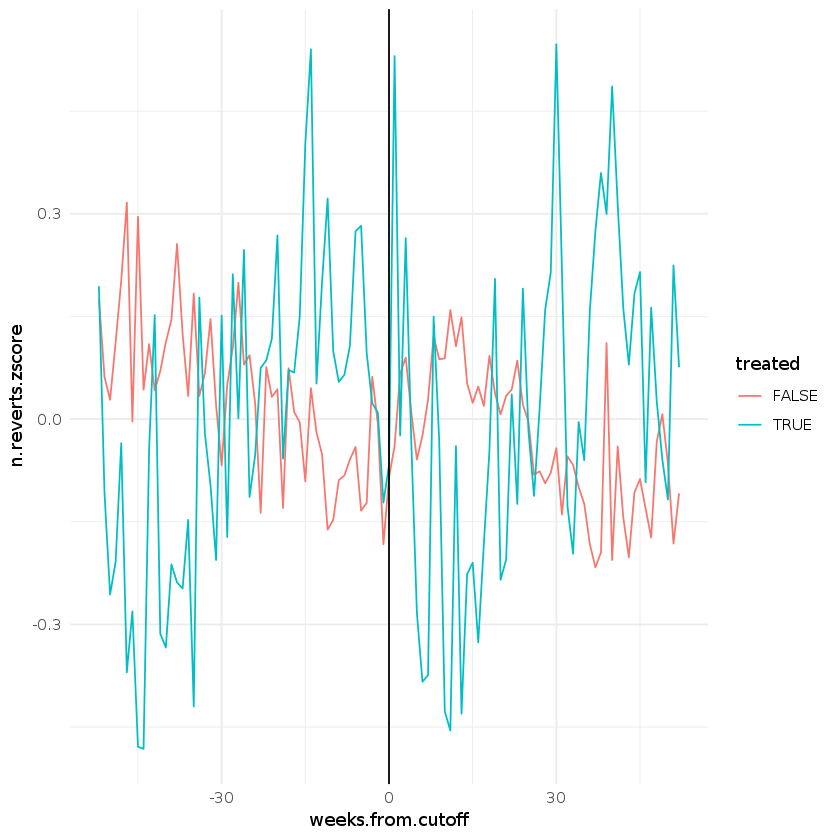

In [383]:
ggplot(bytreated,aes(x=weeks.from.cutoff,y=n.reverts.zscore,group=treated,color=treated)) + geom_line() + geom_vline(xintercept=0)

In [385]:
bytreated_weighted = df[,lapply(.SD, function(x) mean(x * ip.weight, na.rm=T)),by=.(treated,weeks.from.cutoff),.SDcols=c("n.reverts.zscore","geom.mean.ttr.zscore","n.anon.reverts.zscore")]

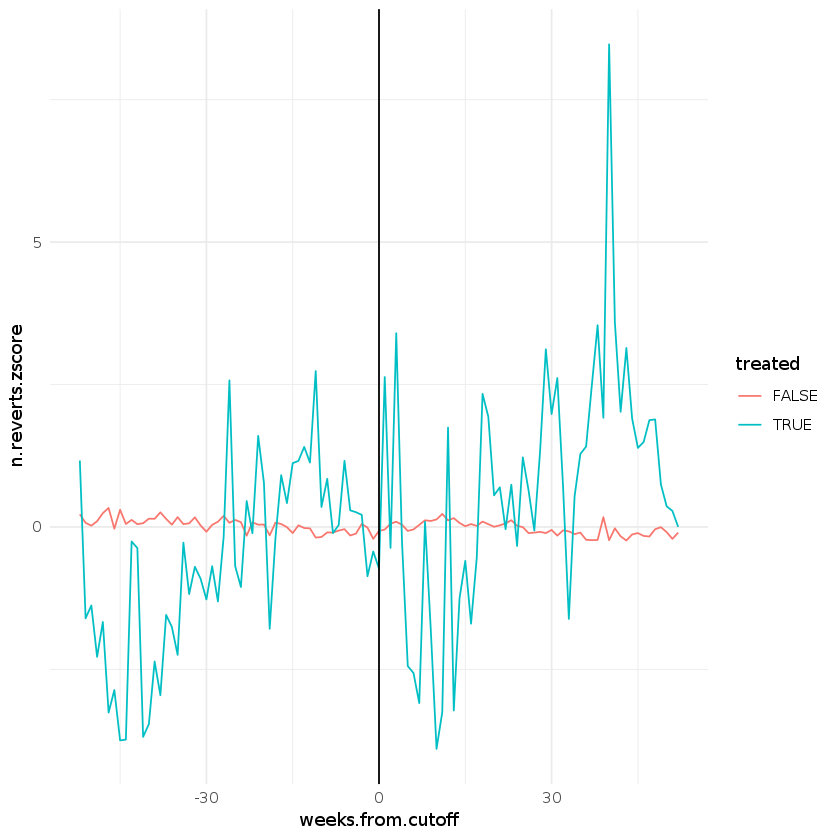

In [386]:
ggplot(bytreated_weighted,aes(x=weeks.from.cutoff,y=n.reverts.zscore,group=treated,color=treated)) + geom_line() + geom_vline(xintercept=0)

In [ ]:
# what if we aggregate by month? 
df3 <- df[, .(wiki.db,n.reverts,geom.mean.ttr,anonymous.n.reverted,treated,cutoff,month=floor_date(week,unit='month'),ip.weight)]

In [ ]:
df3 <- df3[,.(n.reverts=sum(n.reverts),geom.mean.ttr=sum(geom.mean.ttr),anonymous.n.reverted=sum(anonymous.n.reverted),cutoff=first(cutoff),treated=first(treated),ip.weight=first(ip.weight)),by=.(wiki.db,month)]

In [ ]:
df3 <- df3[,":="(months.from.cutoff = round((df3$month - df3$cutoff)/dweeks(4)))]

In [ ]:
df3 <- df3[,":="(n.reverts.zscore = (n.reverts - mean(n.reverts))/sd(n.reverts),
                first.month = min(month), last.month = max(month)
                ),by=.(wiki.db)]

In [ ]:
df3 <- df3[(month != first.month) & (month != last.month)]

In [ ]:
ggplot(df3[treated==T], aes(x=months.from.cutoff,y=n.reverts)) + geom_line() + theme(legend.position="none") + geom_vline(xintercept=0,linetype='dashed')  + facet_wrap(.~wiki.db,scales = 'free') + 

In [ ]:
ggplot(df4, aes(x=months.from.cutoff,y=reverts, group=treated, color=treated)) + geom_line() + geom_vline(xintercept=0,linetype='dashed')

In [ ]:
df4 <- df3[,.(reverts = mean(n.reverts.zscore), reverts.weighted = mean(n.reverts.zscore * ip.weight),month=first(month)),by=.(treated,months.from.cutoff)]

In [ ]:
ggplot(df4, aes(x=months.from.cutoff,y=reverts.weighted, group=treated, color=treated)) + geom_line() + geom_vline(xintercept=0,linetype='dashed')

wiki.db,ip.weight,treated
acewiki,1.038653,FALSE
afwiki,1.047455,FALSE
alswiki,1.035790,FALSE
amwiki,1.058082,FALSE
angwiki,1.027778,FALSE
anwiki,1.039279,FALSE
arwiki,2.739010,TRUE
arwikibooks,1.051840,FALSE
arwikinews,1.036531,FALSE
arwikiquote,1.029859,FALSE


In [333]:
names(df)

[1] "wiki.db"                         "week"                           
  [3] "mean.user.reverts"               "n.reverts"                      
  [5] "user.week.var"                   "revert.hhi"                     
  [7] "user.week.sd"                    "user.week.revert.cv"            
  [9] "total.edits"                     "active.editors"                 
 [11] "mean.ttr"                        "sd.ttr"                         
 [13] "geom.mean.ttr"                   "med.ttr"                        
 [15] "N.revert"                        "admin.mean.ttr"                 
 [17] "admin.sd.ttr"                    "admin.geom.mean.ttr"            
 [19] "admin.med.ttr"                   "admin.N.reverts"                
 [21] "bot.mean.ttr"                    "bot.sd.ttr"                     
 [23] "bot.geom.mean.ttr"               "bot.med.ttr"                    
 [25] "bot.N.reverts"                   "patroller.mean.ttr"             
 [27] "patroller.sd.ttr"                "patroller.geom.mean.ttr"        
 [29] "patroller.med.ttr"               "patroller.N.reverts"            
 [31] "other.mean.ttr"                  "other.sd.ttr"                   
 [33] "other.geom.mean.ttr"             "other.med.ttr"                  
 [35] "other.N.reverts"                 "newcomer.n.reverted"            
 [37] "newcomer.mean.ttr"               "anonymous.n.reverted"           
 [39] "anonymous.mean.ttr"              "established.n.reverted"         
 [41] "established.mean.ttr"            "ns0.anon.N.edits"               
 [43] "ns0.anon.N.editors"              "ns0.newcomer.N.edits"           
 [45] "ns0.newcomer.N.editors"          "ns0.non.anon.newcomer.N.edits"  
 [47] "ns0.non.anon.newcomer.N.editors" "ns1.anon.N.edits"               
 [49] "ns1.anon.N.editors"              "ns1.newcomer.N.edits"           
 [51] "ns1.newcomer.N.editors"          "ns1.non.anon.newcomer.N.edits"  
 [53] "ns1.non.anon.newcomer.N.editors" "ns2.anon.N.edits"               
 [55] "ns2.anon.N.editors"              "ns2.newcomer.N.edits"           
 [57] "ns2.newcomer.N.editors"          "ns2.non.anon.newcomer.N.edits"  
 [59] "ns2.non.anon.newcomer.N.editors" "ns3.anon.N.edits"               
 [61] "ns3.anon.N.editors"              "ns3.newcomer.N.edits"           
 [63] "ns3.newcomer.N.editors"          "ns3.non.anon.newcomer.N.edits"  
 [65] "ns3.non.anon.newcomer.N.editors" "ns4.anon.N.edits"               
 [67] "ns4.anon.N.editors"              "ns4.newcomer.N.edits"           
 [69] "ns4.newcomer.N.editors"          "ns4.non.anon.newcomer.N.edits"  
 [71] "ns4.non.anon.newcomer.N.editors" "project"                        
 [73] "date"                            "view.count"                     
 [75] "n.pages.created.ns.0"            "n.pages.created.ns.1"           
 [77] "n.pages.created.ns.2"            "n.pages.created.ns.3"           
 [79] "n.pages.created.ns.4"            "n.pages.baseline.ns.0"          
 [81] "n.pages.baseline.ns.1"           "n.pages.baseline.ns.2"          
 [83] "n.pages.baseline.ns.3"           "n.pages.baseline.ns.4"          
 [85] "treated"                         "cutoff"                         
 [87] "weeks.from.cutoff"               "has.ores"                       
 [89] "week.factor"                     "weekly.ns4.edits"               
 [91] "p.ns4.edits.anon"                "p.ns4.edits.newcomer"           
 [93] "p.ns4.edits.established"         "ns0.edits"                      
 [95] "p.ns0.edits.anon"                "p.ns0.edits.newcomer"           
 [97] "p.ns0.edits.established"         "p.reverts.bot"                  
 [99] "p.reverts.admin"                 "p.reverts.patroller"            
[101] "p.reverts.other"                 "n.reverteds"                    
[103] "p.reverteds.newcomer"            "p.reverteds.anonymous"          
[105] "p.reverteds.established"         "has.patrollers"                 
[107] "treated.with.ores"               "treated.y"                      
[109] 

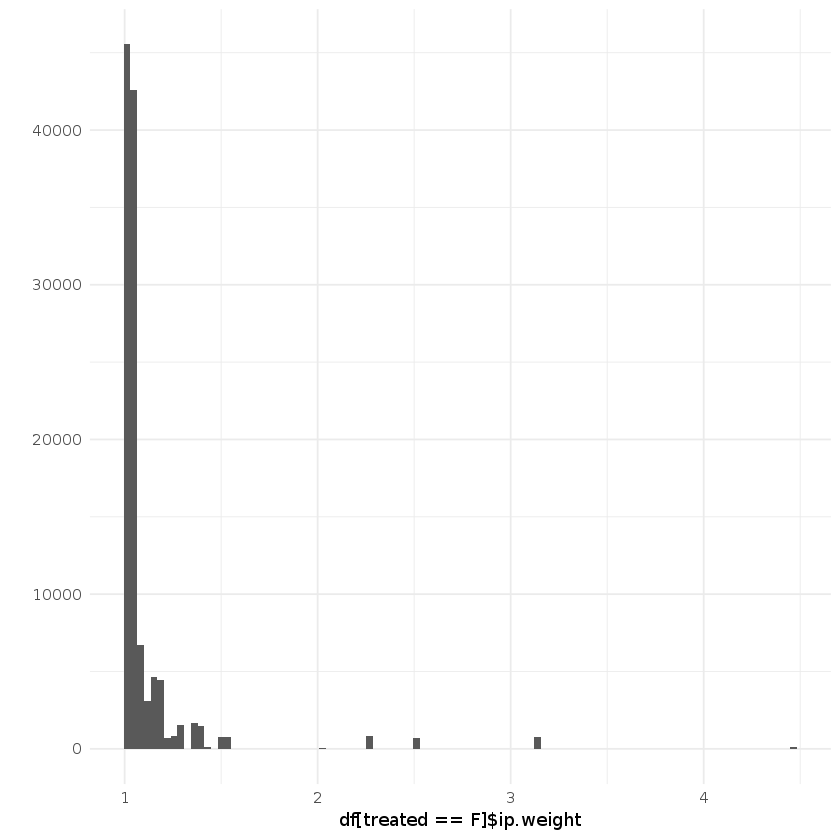

In [347]:
qplot(df[treated==F]$ip.weight,bins=100)

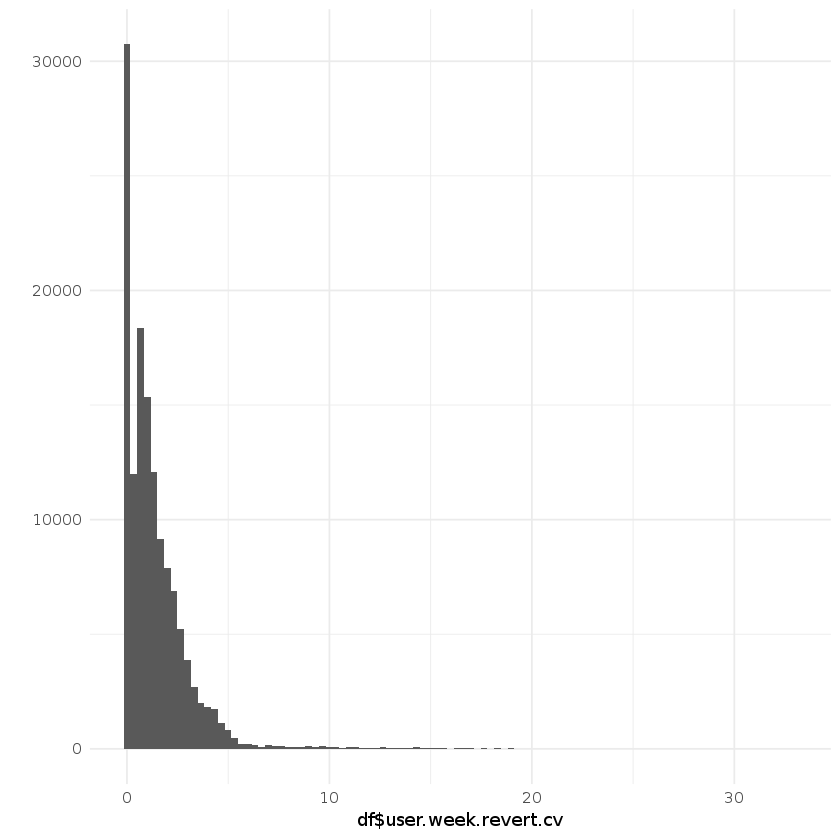

In [342]:
qplot(df$user.week.revert.cv,bins=100)

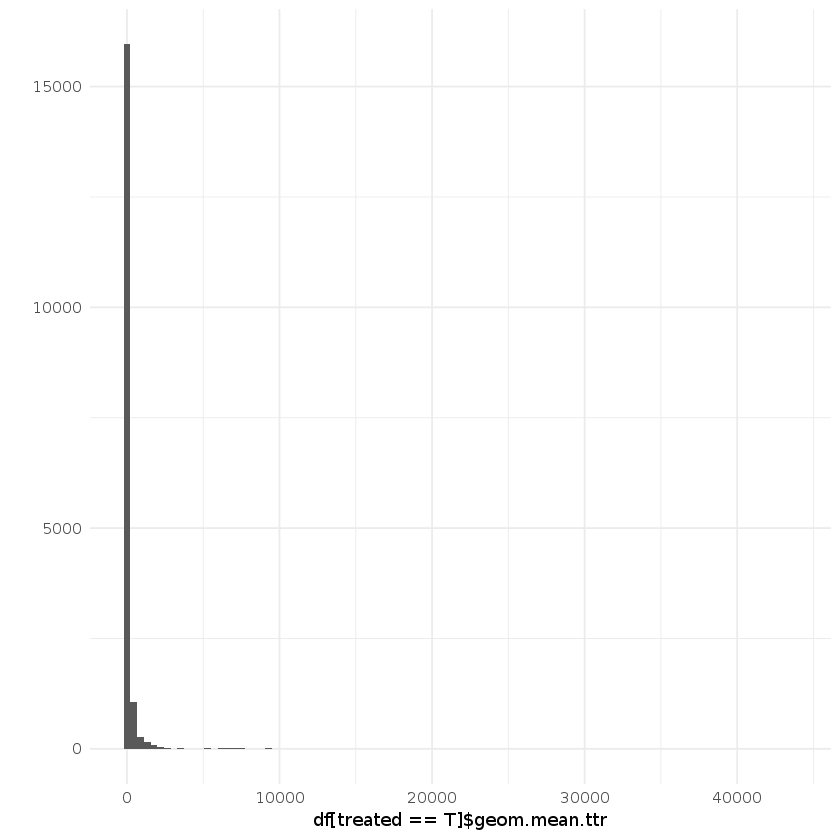

In [332]:
qplot(df[treated==T]$geom.mean.ttr,bins=100)

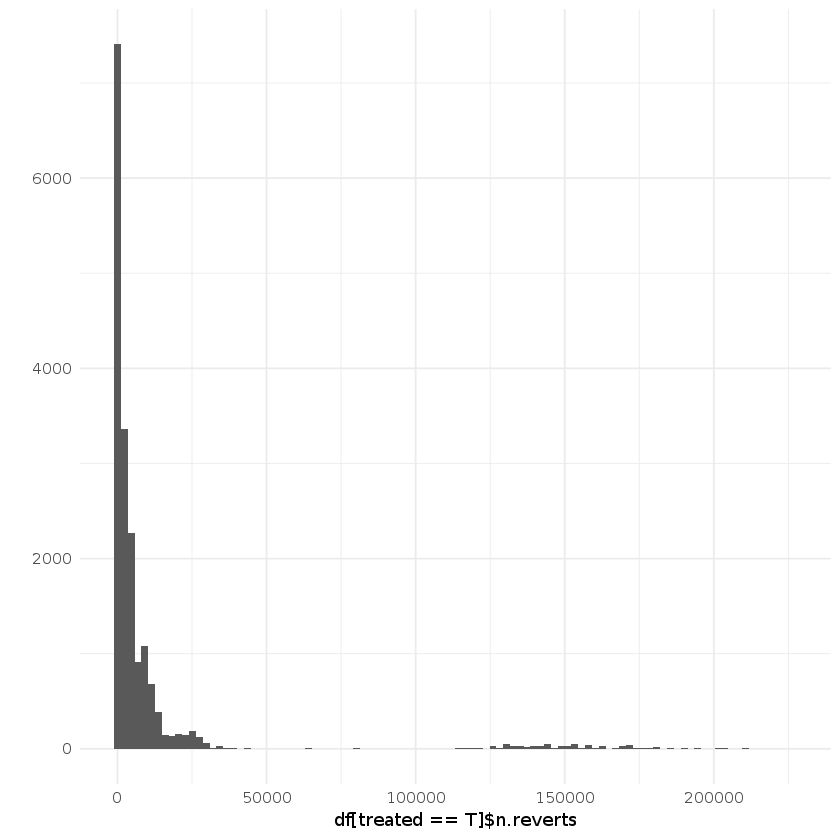

In [331]:
qplot(df[treated==T]$n.reverts,bins=100)

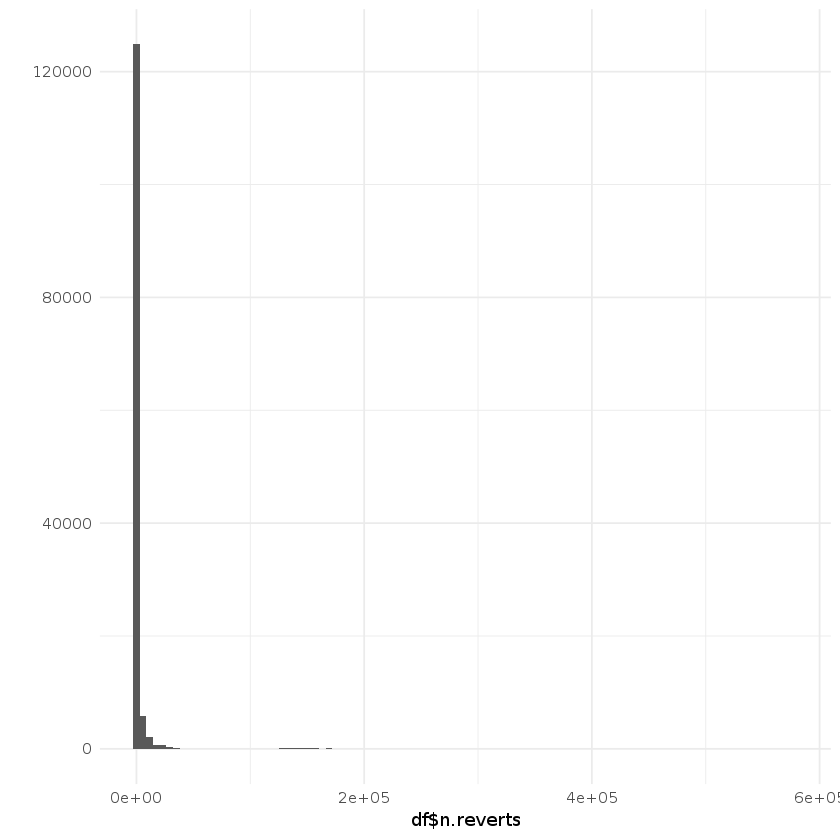

In [329]:
qplot(df$n.reverts,bins=100)

Warning message:
“Removed 25379 rows containing non-finite values (stat_bin).”

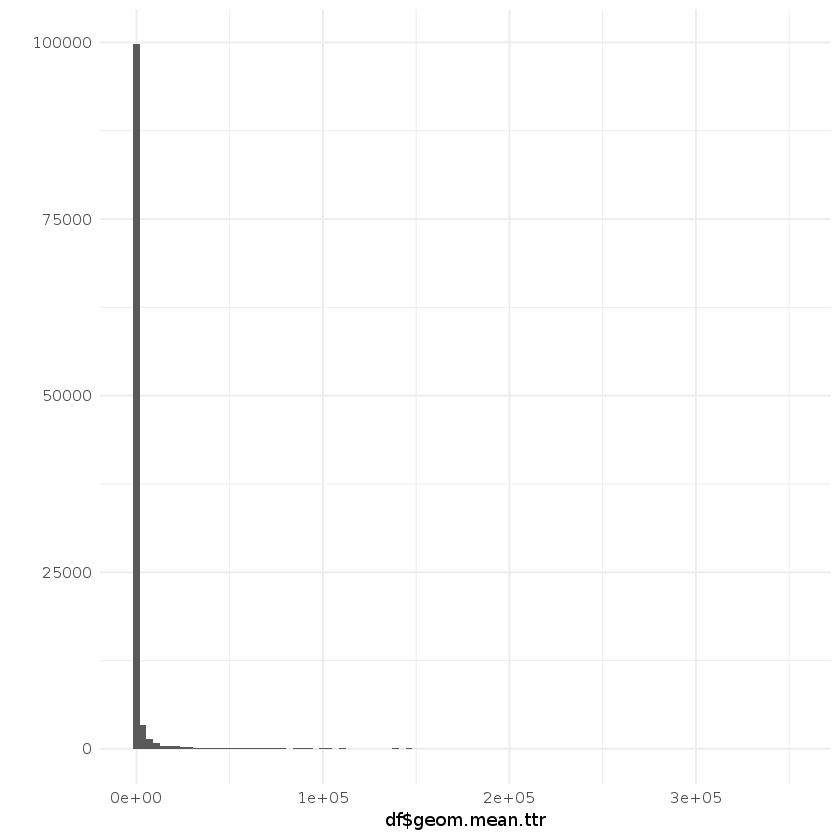

In [328]:
qplot(df$geom.mean.ttr,bins=100)